In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision.transforms import ToTensor
import timm
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

В рамках DL экспериментов мы разморозили веса Efficientnet V2_l, который использовали ранее, и дообучили на нашем датасете.

В ходе экспериментов мы меняли следующие параметры:

- Количество блоков слоев, участвующих в обучении: от 1 до 7

- Scheduler для параметра learning rate: ReduceLROnPlateau или CosineAnnealingLR

- Классификатор модели: один линейный слой или несколько линейных слоев с ReLu и Dropout

# N_freeze = 0

### N_freeze = 0, ReduceLROnPlateau scheduler, no additional layers

Found 7 classes: ['akiec_augmentations_full_res', 'bcc_augmentations_full_res', 'bkl_augmentations_full_res', 'df_augmentations_full_res', 'mel_augmentations_full_res', 'nv_augmentations_full_res', 'vasc_augmentations_full_res']


Epoch 1/15 [Val]: 100%|██████████| 2077/2077 [00:51<00:00, 40.04it/s, loss=0.8404]


Epoch 1/15 completed - Train Loss: 0.8779, Val Loss: 0.5673, Val Accuracy: 80.44%, Val Precision: 0.7624, Val Recall: 0.7449

Best model saved at epoch 1 with val loss: 0.5673


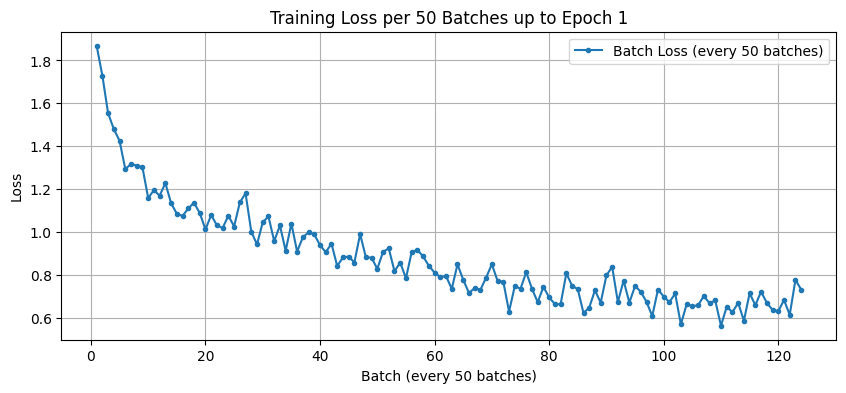

Epoch 2/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.43it/s, loss=0.6068]

Epoch 2/15 completed - Train Loss: 0.5065, Val Loss: 0.4164, Val Accuracy: 85.74%, Val Precision: 0.7933, Val Recall: 0.8478

Best model saved at epoch 2 with val loss: 0.4164


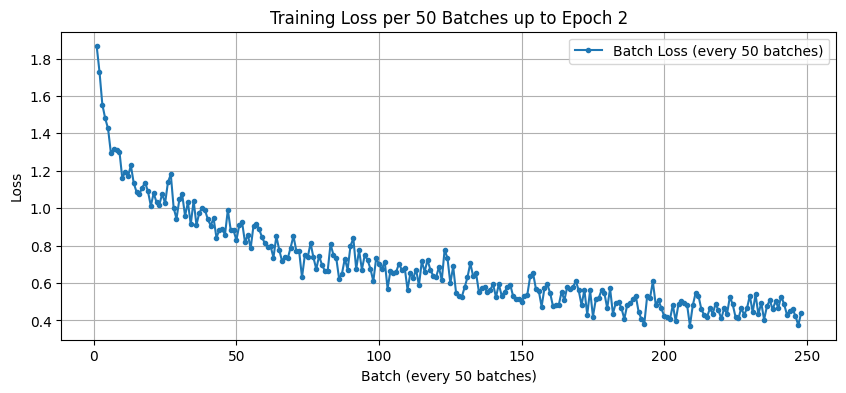

Epoch 3/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.38it/s, loss=0.5610]

Epoch 3/15 completed - Train Loss: 0.3468, Val Loss: 0.3581, Val Accuracy: 87.70%, Val Precision: 0.8395, Val Recall: 0.8858

Best model saved at epoch 3 with val loss: 0.3581


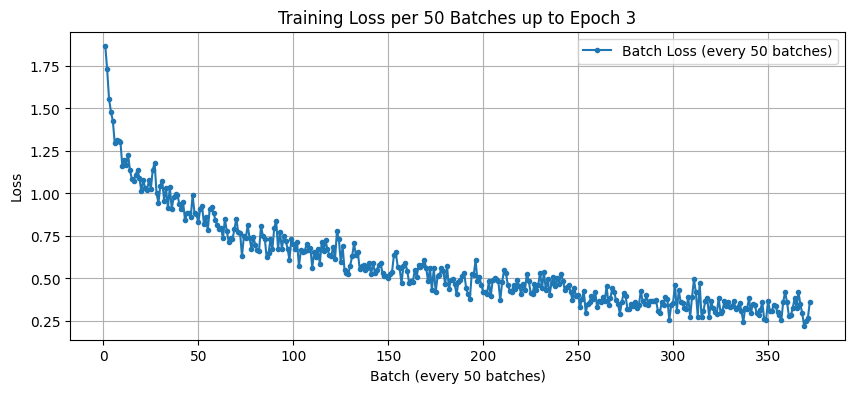

Epoch 4/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.20it/s, loss=0.4967]

Epoch 4/15 completed - Train Loss: 0.2330, Val Loss: 0.2835, Val Accuracy: 90.59%, Val Precision: 0.8460, Val Recall: 0.9199

Best model saved at epoch 4 with val loss: 0.2835


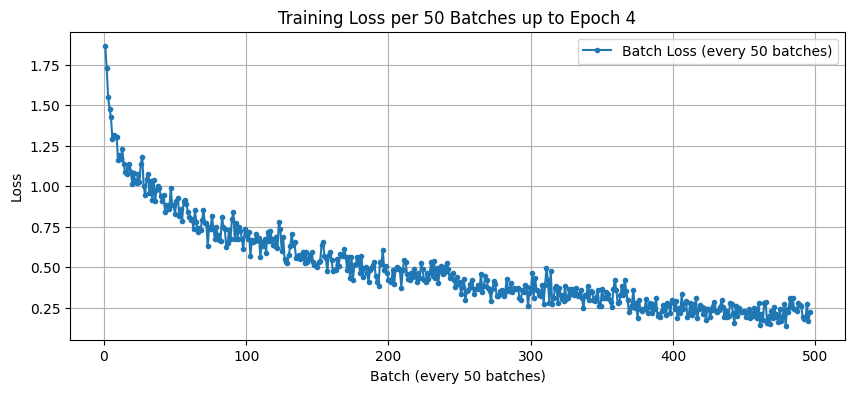

Epoch 5/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.29it/s, loss=0.5444]

Epoch 5/15 completed - Train Loss: 0.1521, Val Loss: 0.2935, Val Accuracy: 90.14%, Val Precision: 0.8258, Val Recall: 0.9233



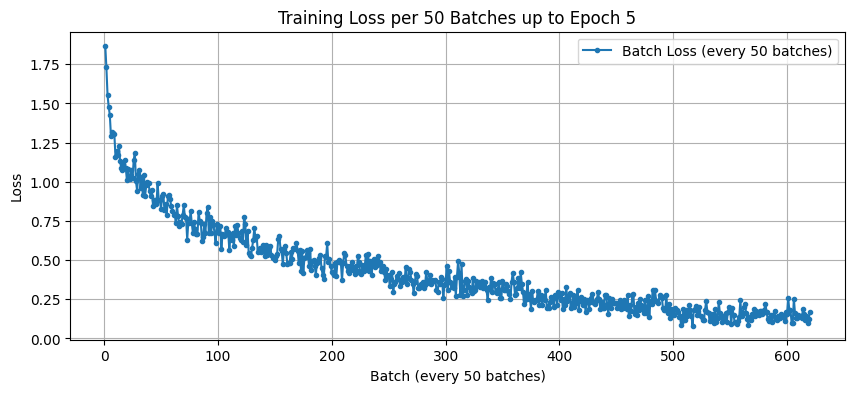

Epoch 6/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.14it/s, loss=0.1048]  

Epoch 6/15 completed - Train Loss: 0.1066, Val Loss: 0.3620, Val Accuracy: 91.91%, Val Precision: 0.8608, Val Recall: 0.9343

Early stopping triggered after 6 epochs.


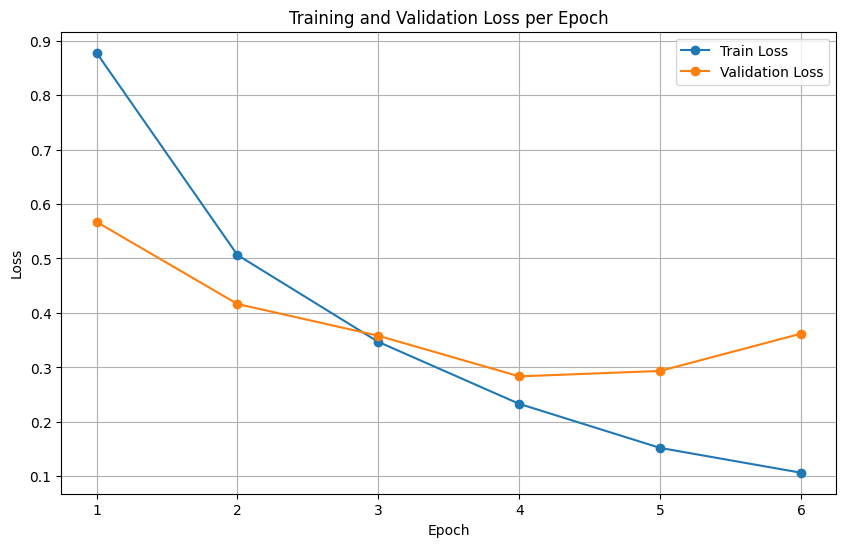

In [3]:
# Hyperparams:
lr = 1e-5
train_ratio = 0.75
batch_size = 4
epochs = 15
early_stop_patience = 2
N_freeze = 0 # max value 6 because totally 7 blocks
best_model_path = 'best_model_n_0_plwateau_s.pt'

data_dir = "C:/Users/User/images/450/"

# Define transforms: convert to tensor and normalize as per ImageNet stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
print(f"Found {num_classes} classes: {dataset.classes}")

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True)

# Adding new head:
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, num_classes)
)

if N_freeze > 0:
    for param in model.conv_stem.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for idx, block in enumerate(model.blocks.children()):
        if idx < N_freeze:
            for param in block.parameters():
                param.requires_grad = False
        else:
            break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Trying different schedulers:

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

train_losses, val_losses = [], []
batch_losses = []

best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    epoch_batch_losses = []
    train_bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}/{epochs} [Train]")

    for batch_idx, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        batch_loss += loss.item()

        if batch_idx % 50 == 0:
            avg_batch_loss = batch_loss / 50
            epoch_batch_losses.append(avg_batch_loss)
            batch_loss = 0.0

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    batch_losses.extend(epoch_batch_losses)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels, all_preds = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Epoch {epoch}/{epochs} completed - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}\n")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} with val loss: {best_val_loss:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(batch_losses) + 1), batch_losses, label='Batch Loss (every 50 batches)', marker='.')
    plt.xlabel('Batch (every 50 batches)')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per 50 Batches up to Epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

### N_freeze = 0, CosineAnnealingLR scheduler, no additional layers

Found 7 classes: ['akiec_augmentations_full_res', 'bcc_augmentations_full_res', 'bkl_augmentations_full_res', 'df_augmentations_full_res', 'mel_augmentations_full_res', 'nv_augmentations_full_res', 'vasc_augmentations_full_res']


Epoch 1/15 [Val]: 100%|██████████| 2077/2077 [00:52<00:00, 39.21it/s, loss=1.6046]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/15 completed - Train Loss: 0.8699, Val Loss: 0.5094, Val Accuracy: 82.75%, Val Precision: 0.8087, Val Recall: 0.7558

Best model saved at epoch 1 with val loss: 0.5094


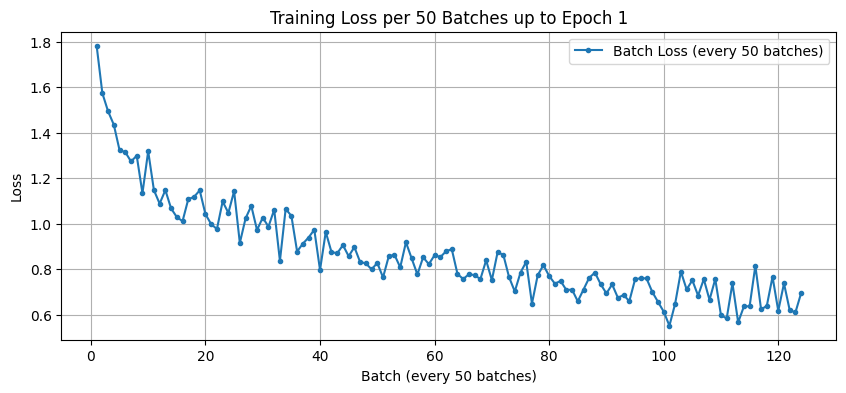

Epoch 2/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.75it/s, loss=1.0211] 
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/15 completed - Train Loss: 0.5020, Val Loss: 0.4830, Val Accuracy: 85.03%, Val Precision: 0.8014, Val Recall: 0.8452

Best model saved at epoch 2 with val loss: 0.4830


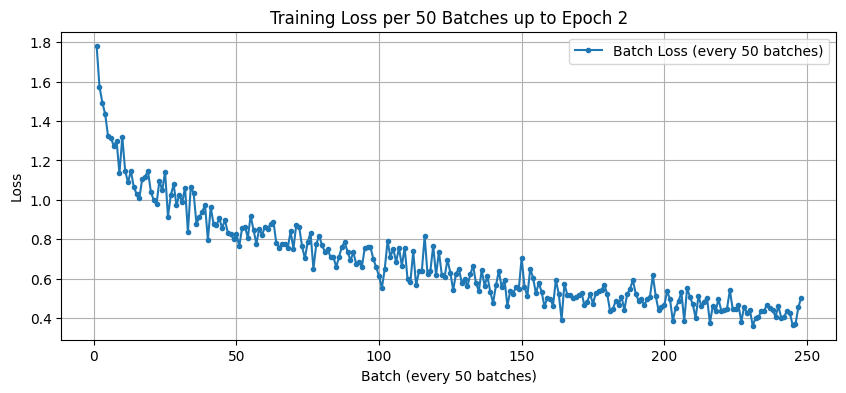

Epoch 3/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.57it/s, loss=0.9113]  

Epoch 3/15 completed - Train Loss: 0.3434, Val Loss: 0.6201, Val Accuracy: 87.42%, Val Precision: 0.8130, Val Recall: 0.8849




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


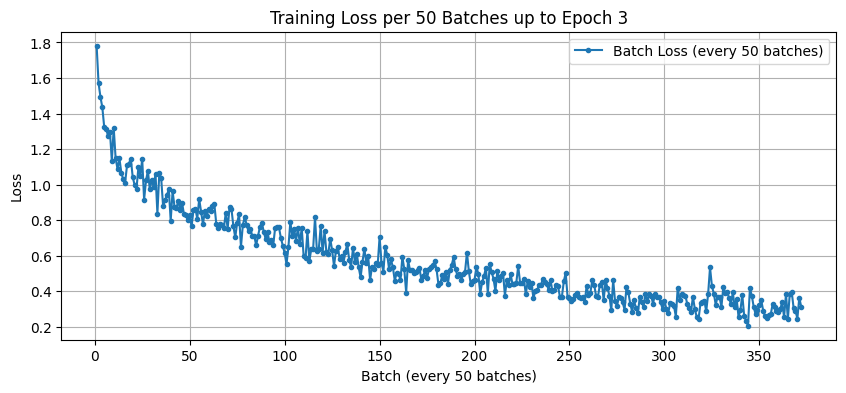

Epoch 4/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.59it/s, loss=0.5603]

Epoch 4/15 completed - Train Loss: 0.2311, Val Loss: 0.2411, Val Accuracy: 91.82%, Val Precision: 0.8860, Val Recall: 0.9282

Best model saved at epoch 4 with val loss: 0.2411



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


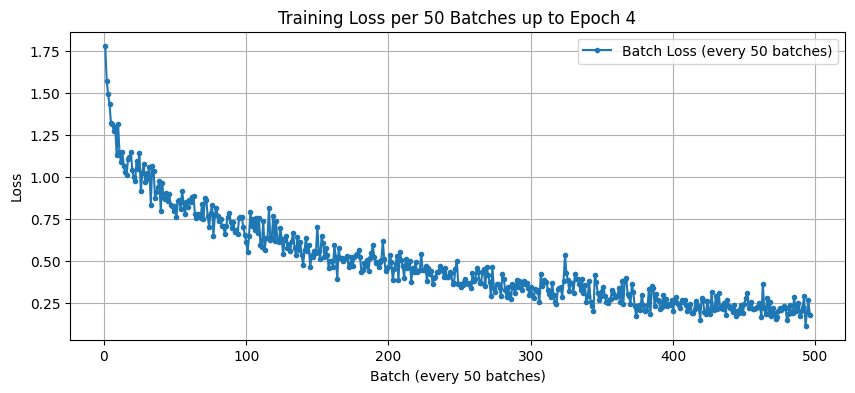

Epoch 5/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.60it/s, loss=0.2454]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5/15 completed - Train Loss: 0.1483, Val Loss: 0.2307, Val Accuracy: 92.30%, Val Precision: 0.8798, Val Recall: 0.9373

Best model saved at epoch 5 with val loss: 0.2307


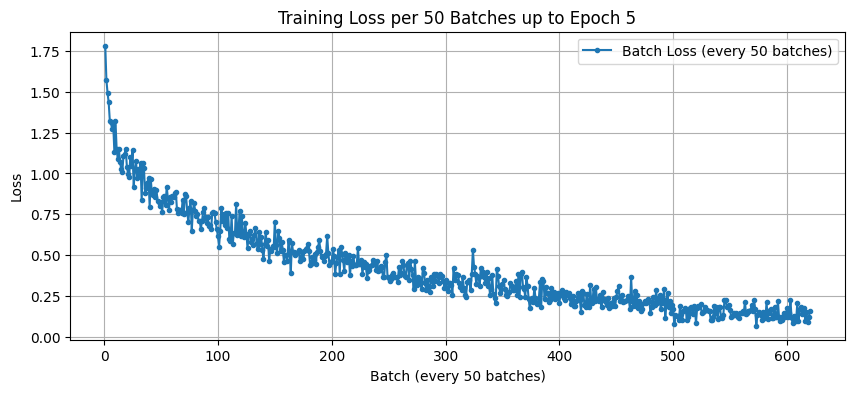

Epoch 6/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.71it/s, loss=0.2961]

Epoch 6/15 completed - Train Loss: 0.1028, Val Loss: 0.2157, Val Accuracy: 93.09%, Val Precision: 0.8881, Val Recall: 0.9448

Best model saved at epoch 6 with val loss: 0.2157



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


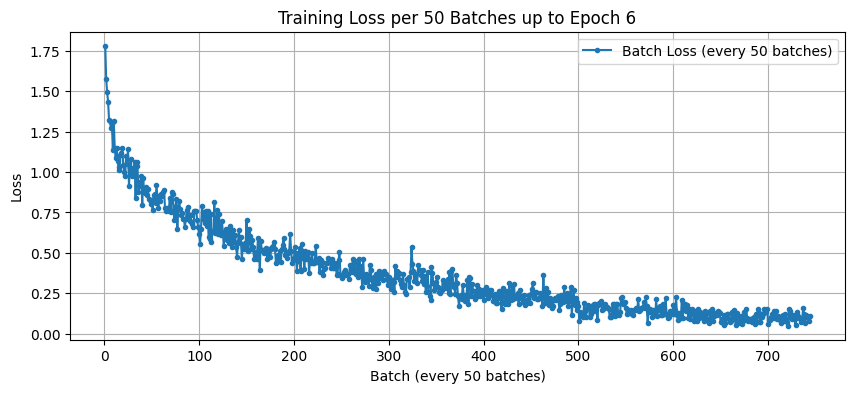

Epoch 7/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.57it/s, loss=0.5746]

Epoch 7/15 completed - Train Loss: 0.0736, Val Loss: 0.2035, Val Accuracy: 93.61%, Val Precision: 0.9112, Val Recall: 0.9455

Best model saved at epoch 7 with val loss: 0.2035



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


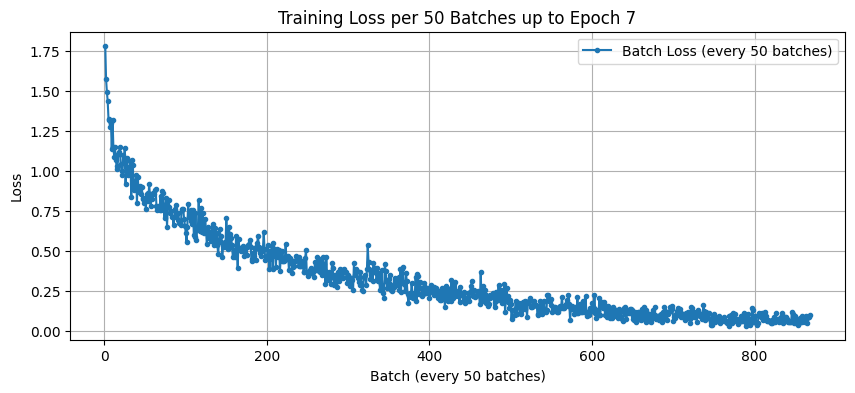

Epoch 8/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.53it/s, loss=0.0778]

Epoch 8/15 completed - Train Loss: 0.0544, Val Loss: 0.2119, Val Accuracy: 93.08%, Val Precision: 0.8655, Val Recall: 0.9478




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


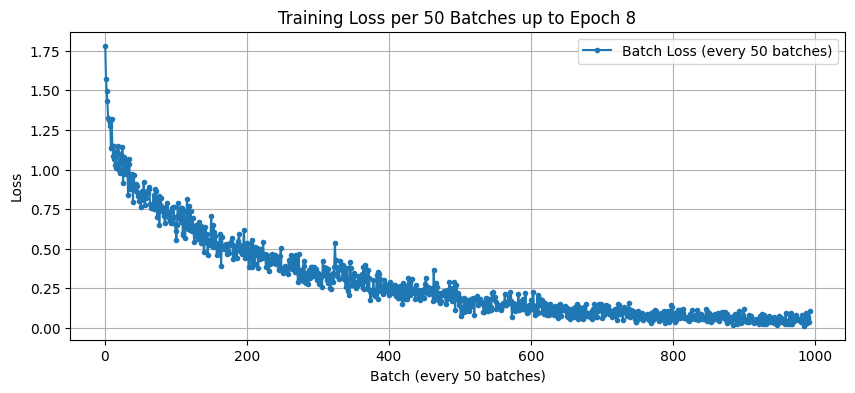

Epoch 9/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.51it/s, loss=0.0212]

Epoch 9/15 completed - Train Loss: 0.0428, Val Loss: 0.1611, Val Accuracy: 94.63%, Val Precision: 0.9054, Val Recall: 0.9598

Best model saved at epoch 9 with val loss: 0.1611



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


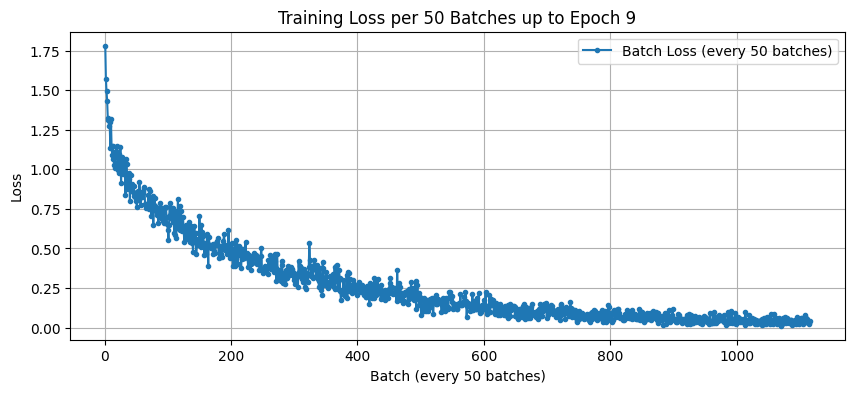

Epoch 10/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.65it/s, loss=0.1729]

Epoch 10/15 completed - Train Loss: 0.0314, Val Loss: 0.1837, Val Accuracy: 94.61%, Val Precision: 0.9104, Val Recall: 0.9570




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


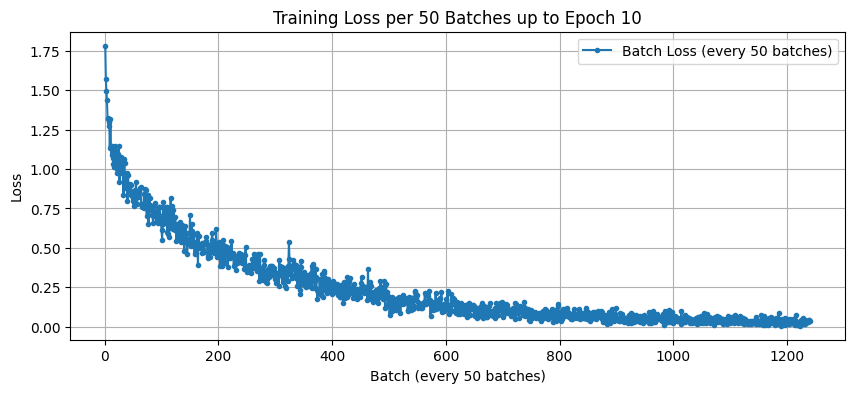

Epoch 11/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.44it/s, loss=0.1536]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 11/15 completed - Train Loss: 0.0296, Val Loss: 0.1390, Val Accuracy: 95.76%, Val Precision: 0.9425, Val Recall: 0.9613

Best model saved at epoch 11 with val loss: 0.1390


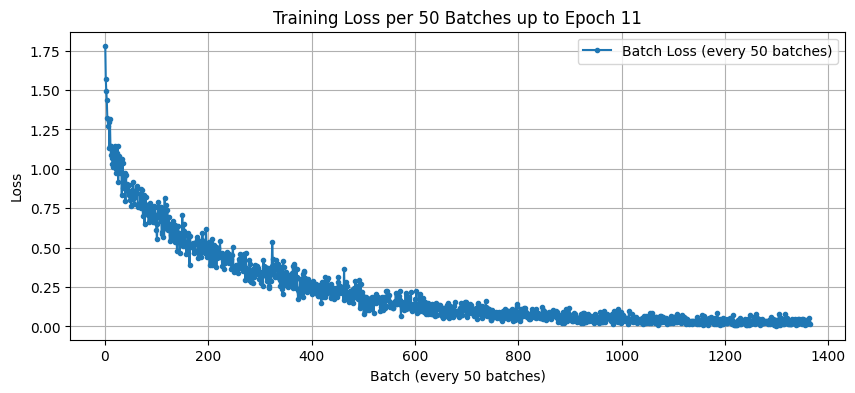

Epoch 12/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.51it/s, loss=0.2017]

Epoch 12/15 completed - Train Loss: 0.0251, Val Loss: 0.1746, Val Accuracy: 94.69%, Val Precision: 0.9084, Val Recall: 0.9607




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


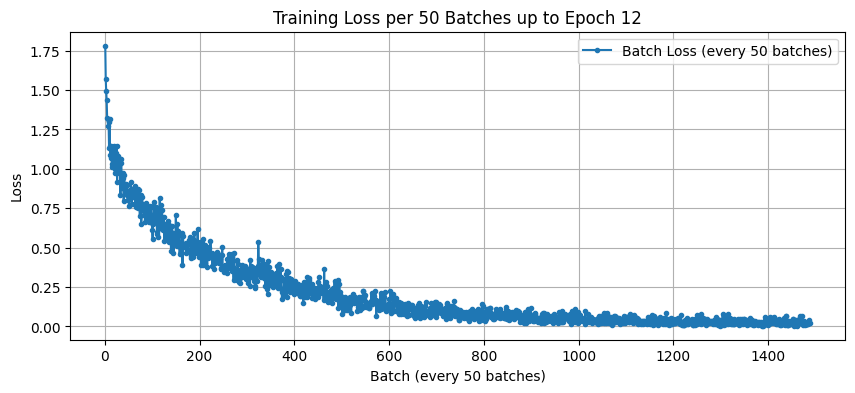

Epoch 13/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.53it/s, loss=0.1395] 

Epoch 13/15 completed - Train Loss: 0.0228, Val Loss: 0.2907, Val Accuracy: 94.76%, Val Precision: 0.9151, Val Recall: 0.9580

Early stopping triggered after 13 epochs.



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


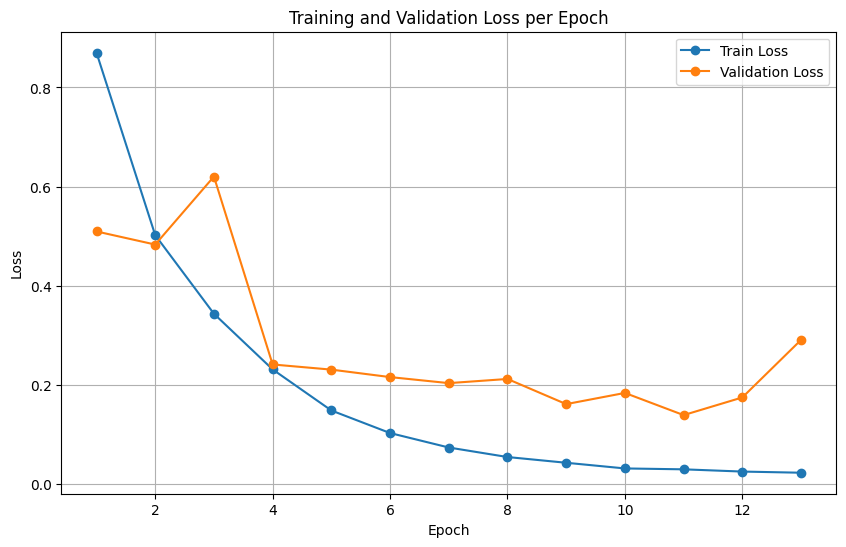

In [4]:
# Hyperparams:
lr = 1e-5
train_ratio = 0.75
batch_size = 4
epochs = 15
early_stop_patience = 2
N_freeze = 0 # max value 6 because totally 7 blocks
best_model_path = 'best_model_n_0_cosine_s.pt'

data_dir = "C:/Users/User/images/450/"

# Define transforms: convert to tensor and normalize as per ImageNet stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
print(f"Found {num_classes} classes: {dataset.classes}")

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True)

# Adding new head:
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, num_classes)
)

if N_freeze > 0:
    for param in model.conv_stem.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for idx, block in enumerate(model.blocks.children()):
        if idx < N_freeze:
            for param in block.parameters():
                param.requires_grad = False
        else:
            break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Trying different schedulers:

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, val_losses = [], []
batch_losses = []

best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    epoch_batch_losses = []
    train_bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}/{epochs} [Train]")

    for batch_idx, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        batch_loss += loss.item()

        if batch_idx % 50 == 0:
            avg_batch_loss = batch_loss / 50
            epoch_batch_losses.append(avg_batch_loss)
            batch_loss = 0.0

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    batch_losses.extend(epoch_batch_losses)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels, all_preds = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Epoch {epoch}/{epochs} completed - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}\n")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} with val loss: {best_val_loss:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(batch_losses) + 1), batch_losses, label='Batch Loss (every 50 batches)', marker='.')
    plt.xlabel('Batch (every 50 batches)')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per 50 Batches up to Epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

### N_freeze = 0, ReduceLROnPlateau scheduler, custom head

Found 7 classes: ['akiec_augmentations_full_res', 'bcc_augmentations_full_res', 'bkl_augmentations_full_res', 'df_augmentations_full_res', 'mel_augmentations_full_res', 'nv_augmentations_full_res', 'vasc_augmentations_full_res']


Epoch 1/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.31it/s, loss=1.4530]

Epoch 1/15 completed - Train Loss: 1.0963, Val Loss: 0.6894, Val Accuracy: 75.60%, Val Precision: 0.6818, Val Recall: 0.5213

Best model saved at epoch 1 with val loss: 0.6894


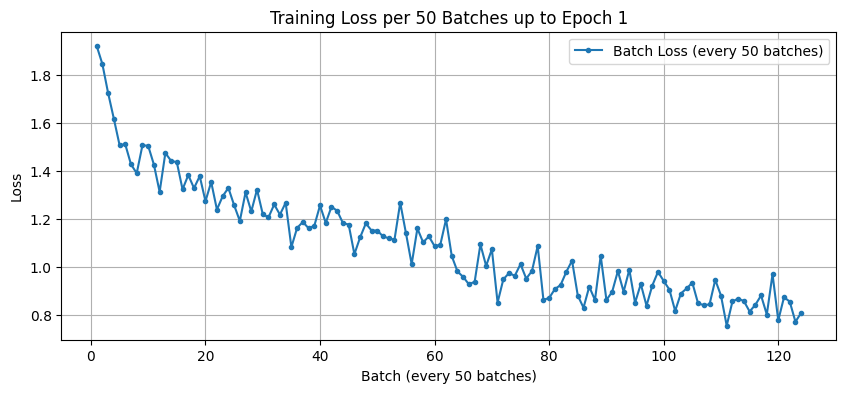

Epoch 2/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.59it/s, loss=1.5475]

Epoch 2/15 completed - Train Loss: 0.6448, Val Loss: 0.4990, Val Accuracy: 82.90%, Val Precision: 0.7961, Val Recall: 0.7348

Best model saved at epoch 2 with val loss: 0.4990


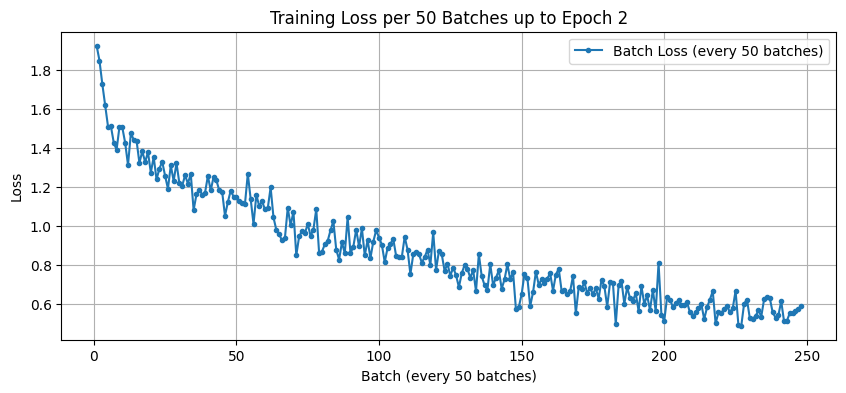

Epoch 3/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.67it/s, loss=1.8677]

Epoch 3/15 completed - Train Loss: 0.4580, Val Loss: 0.4144, Val Accuracy: 86.01%, Val Precision: 0.8131, Val Recall: 0.8217

Best model saved at epoch 3 with val loss: 0.4144


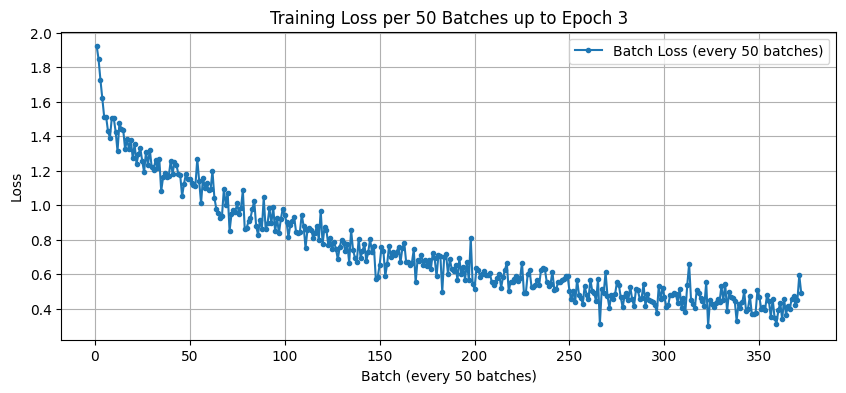

Epoch 4/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.63it/s, loss=1.5529]

Epoch 4/15 completed - Train Loss: 0.3258, Val Loss: 0.3209, Val Accuracy: 88.93%, Val Precision: 0.8279, Val Recall: 0.8813

Best model saved at epoch 4 with val loss: 0.3209


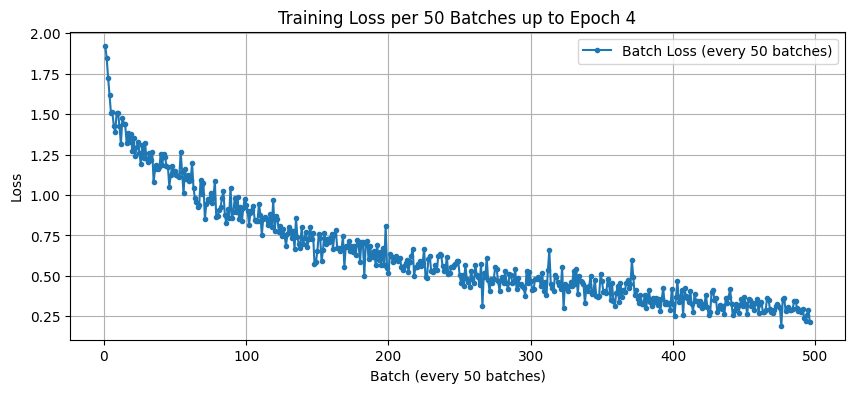

Epoch 5/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.66it/s, loss=2.0832]

Epoch 5/15 completed - Train Loss: 0.2255, Val Loss: 0.2908, Val Accuracy: 90.50%, Val Precision: 0.8727, Val Recall: 0.9109

Best model saved at epoch 5 with val loss: 0.2908


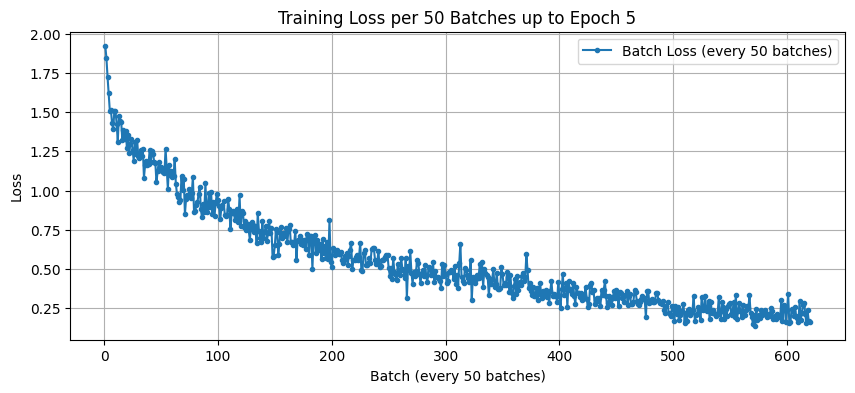

Epoch 6/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.61it/s, loss=1.4003]

Epoch 6/15 completed - Train Loss: 0.1523, Val Loss: 0.3020, Val Accuracy: 90.25%, Val Precision: 0.8418, Val Recall: 0.9223



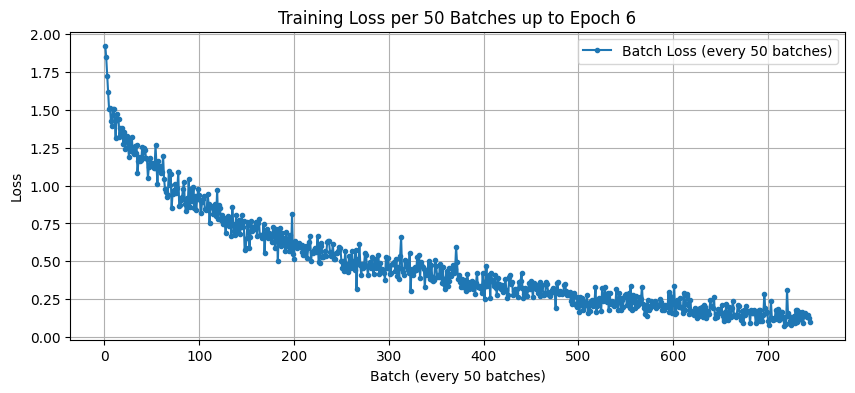

Epoch 7/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.55it/s, loss=0.5391]

Epoch 7/15 completed - Train Loss: 0.1181, Val Loss: 0.2589, Val Accuracy: 91.90%, Val Precision: 0.8528, Val Recall: 0.9345

Best model saved at epoch 7 with val loss: 0.2589


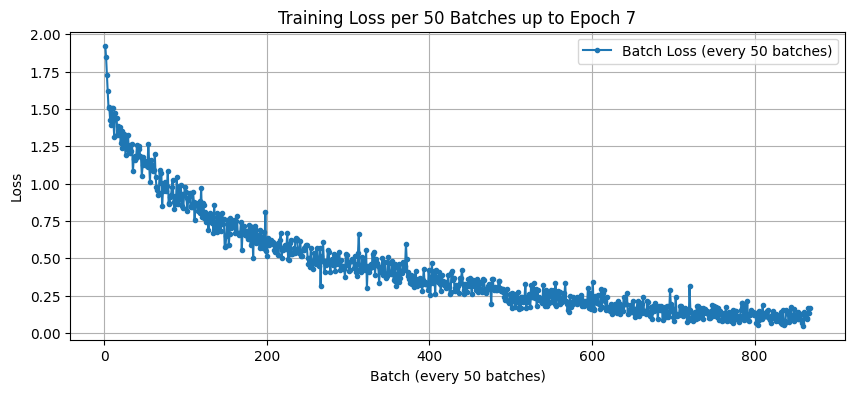

Epoch 8/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.61it/s, loss=2.2949]

Epoch 8/15 completed - Train Loss: 0.0811, Val Loss: 0.3022, Val Accuracy: 91.45%, Val Precision: 0.8625, Val Recall: 0.9342



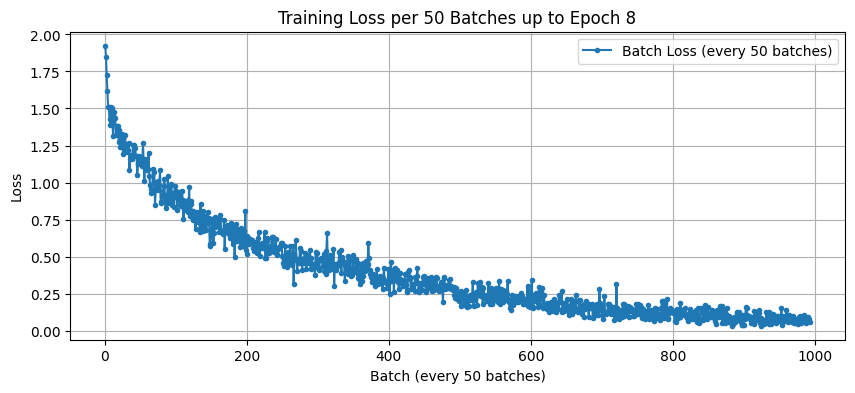

Epoch 9/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.69it/s, loss=0.6832]

Epoch 9/15 completed - Train Loss: 0.0662, Val Loss: 0.2496, Val Accuracy: 92.99%, Val Precision: 0.8774, Val Recall: 0.9426

Best model saved at epoch 9 with val loss: 0.2496


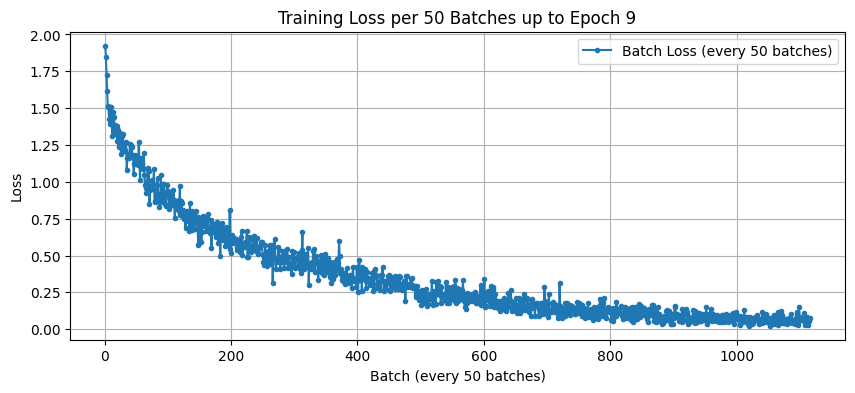

Epoch 10/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.90it/s, loss=2.1813]

Epoch 10/15 completed - Train Loss: 0.0545, Val Loss: 0.2504, Val Accuracy: 93.37%, Val Precision: 0.8930, Val Recall: 0.9446



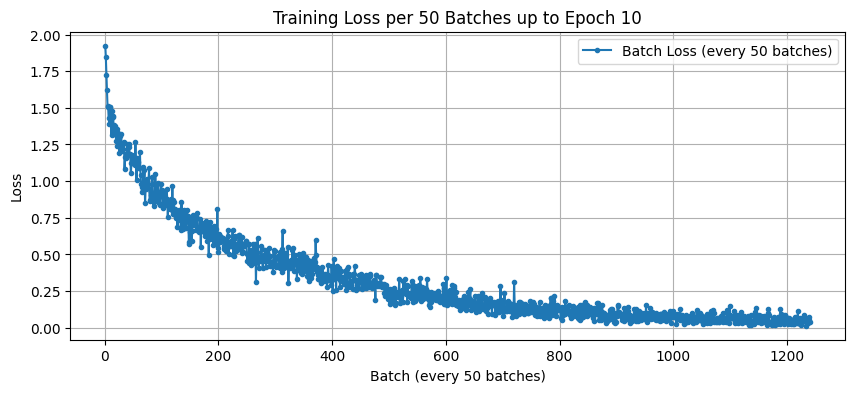

Epoch 11/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.62it/s, loss=1.5458]

Epoch 11/15 completed - Train Loss: 0.0471, Val Loss: 0.1942, Val Accuracy: 94.28%, Val Precision: 0.8901, Val Recall: 0.9557

Best model saved at epoch 11 with val loss: 0.1942


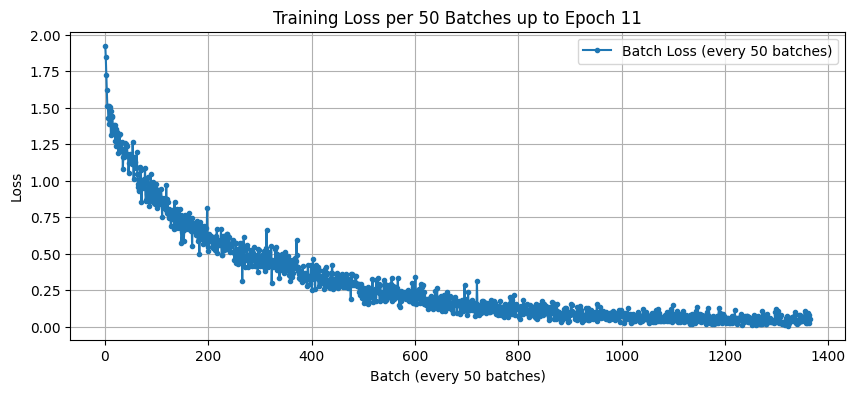

Epoch 12/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.51it/s, loss=0.2334]

Epoch 12/15 completed - Train Loss: 0.0414, Val Loss: 0.2232, Val Accuracy: 93.68%, Val Precision: 0.8795, Val Recall: 0.9528



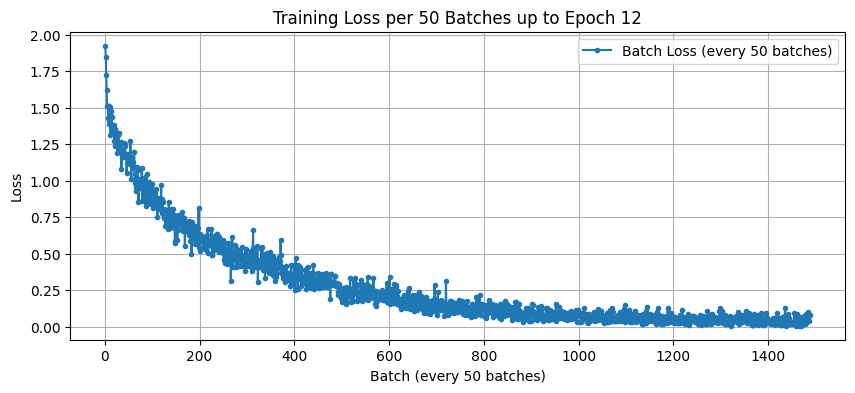

Epoch 13/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.32it/s, loss=0.3769]

Epoch 13/15 completed - Train Loss: 0.0377, Val Loss: 0.2198, Val Accuracy: 94.07%, Val Precision: 0.8868, Val Recall: 0.9532

Early stopping triggered after 13 epochs.


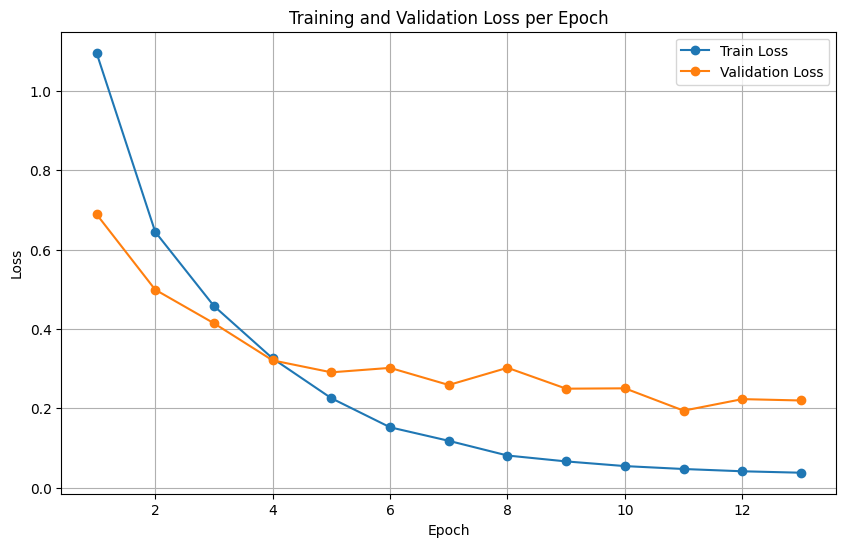

In [5]:
# Hyperparams:
lr = 1e-5
train_ratio = 0.75
batch_size = 4
epochs = 15
early_stop_patience = 2
N_freeze = 0 # max value 6 because totally 7 blocks
best_model_path = 'best_model_n_0_plateau_custom_head_s.pt'

data_dir = "C:/Users/User/images/450/"

# Define transforms: convert to tensor and normalize as per ImageNet stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
print(f"Found {num_classes} classes: {dataset.classes}")

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True)

# Adding custom layers with dropout:
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

if N_freeze > 0:
    for param in model.conv_stem.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for idx, block in enumerate(model.blocks.children()):
        if idx < N_freeze:
            for param in block.parameters():
                param.requires_grad = False
        else:
            break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Trying different schedulers:

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

train_losses, val_losses = [], []
batch_losses = []

best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    epoch_batch_losses = []
    train_bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}/{epochs} [Train]")

    for batch_idx, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        batch_loss += loss.item()

        if batch_idx % 50 == 0:
            avg_batch_loss = batch_loss / 50
            epoch_batch_losses.append(avg_batch_loss)
            batch_loss = 0.0

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    batch_losses.extend(epoch_batch_losses)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels, all_preds = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Epoch {epoch}/{epochs} completed - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}\n")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} with val loss: {best_val_loss:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(batch_losses) + 1), batch_losses, label='Batch Loss (every 50 batches)', marker='.')
    plt.xlabel('Batch (every 50 batches)')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per 50 Batches up to Epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

### N_freeze = 0, CosineAnnealingLR scheduler, custom head

Found 7 classes: ['akiec_augmentations_full_res', 'bcc_augmentations_full_res', 'bkl_augmentations_full_res', 'df_augmentations_full_res', 'mel_augmentations_full_res', 'nv_augmentations_full_res', 'vasc_augmentations_full_res']


Epoch 1/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.60it/s, loss=0.8909]

Epoch 1/15 completed - Train Loss: 1.0753, Val Loss: 0.6591, Val Accuracy: 77.60%, Val Precision: 0.6255, Val Recall: 0.6017

Best model saved at epoch 1 with val loss: 0.6591



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


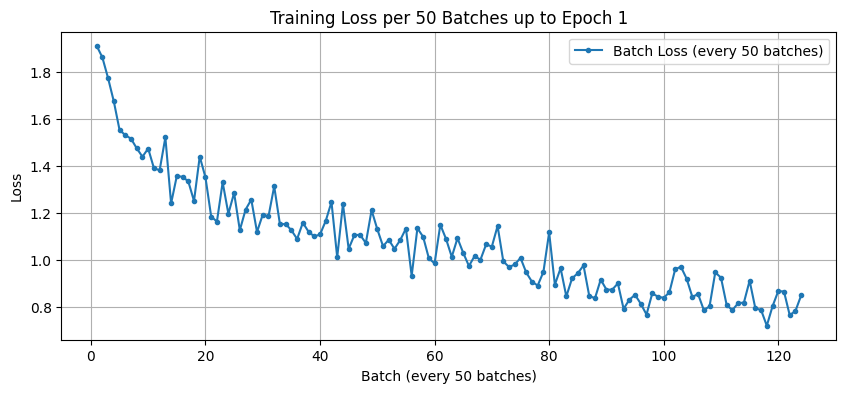

Epoch 2/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.51it/s, loss=0.8865]

Epoch 2/15 completed - Train Loss: 0.6423, Val Loss: 0.4690, Val Accuracy: 83.65%, Val Precision: 0.8039, Val Recall: 0.7344

Best model saved at epoch 2 with val loss: 0.4690



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


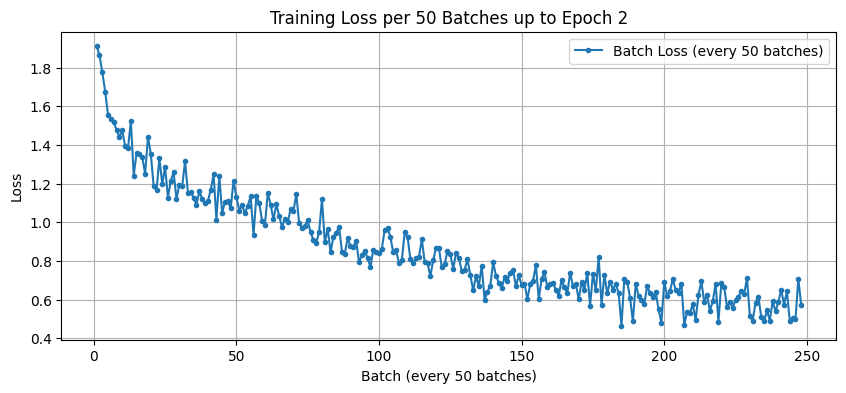

Epoch 3/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.47it/s, loss=1.6021]

Epoch 3/15 completed - Train Loss: 0.4501, Val Loss: 0.3753, Val Accuracy: 87.47%, Val Precision: 0.8221, Val Recall: 0.8316

Best model saved at epoch 3 with val loss: 0.3753



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


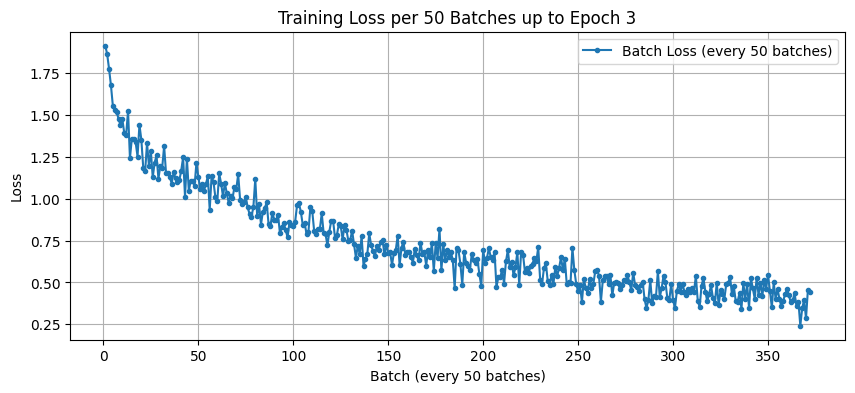

Epoch 4/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.80it/s, loss=0.3006]

Epoch 4/15 completed - Train Loss: 0.3175, Val Loss: 0.3341, Val Accuracy: 88.67%, Val Precision: 0.8213, Val Recall: 0.8924

Best model saved at epoch 4 with val loss: 0.3341



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


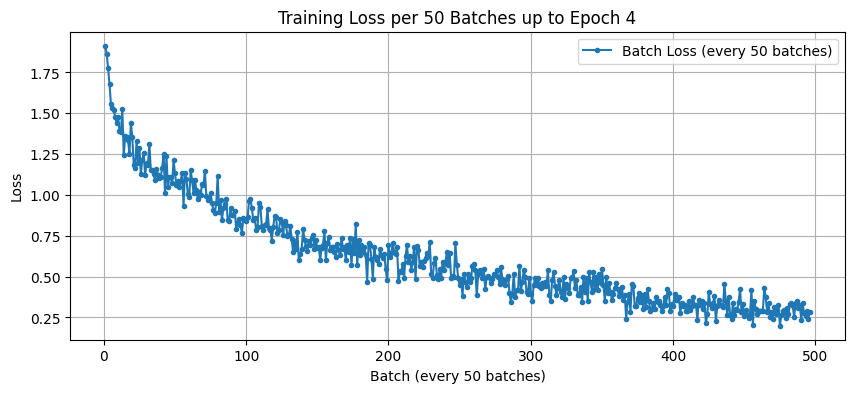

Epoch 5/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.69it/s, loss=0.5446]

Epoch 5/15 completed - Train Loss: 0.2179, Val Loss: 0.2670, Val Accuracy: 91.14%, Val Precision: 0.8671, Val Recall: 0.9207

Best model saved at epoch 5 with val loss: 0.2670



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


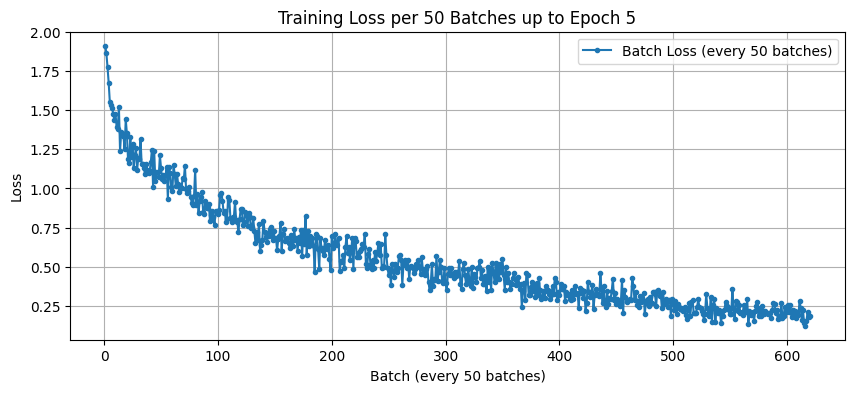

Epoch 6/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.87it/s, loss=0.0308]

Epoch 6/15 completed - Train Loss: 0.1533, Val Loss: 0.3046, Val Accuracy: 89.79%, Val Precision: 0.8619, Val Recall: 0.9196




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


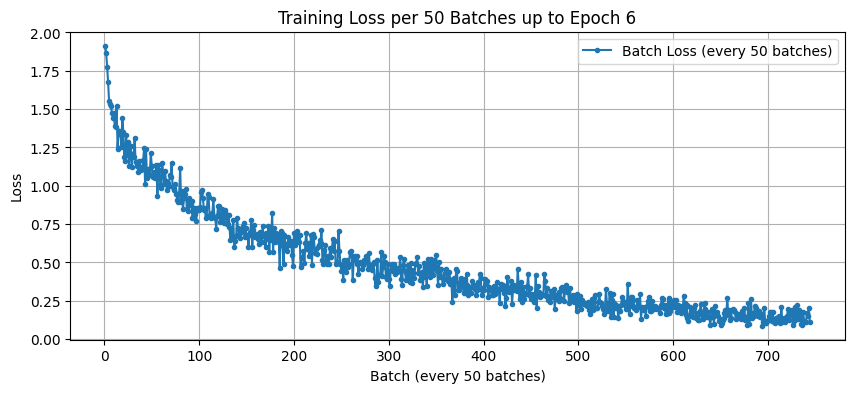

Epoch 7/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.53it/s, loss=0.2435]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 7/15 completed - Train Loss: 0.1102, Val Loss: 0.2254, Val Accuracy: 93.61%, Val Precision: 0.9370, Val Recall: 0.9374

Best model saved at epoch 7 with val loss: 0.2254


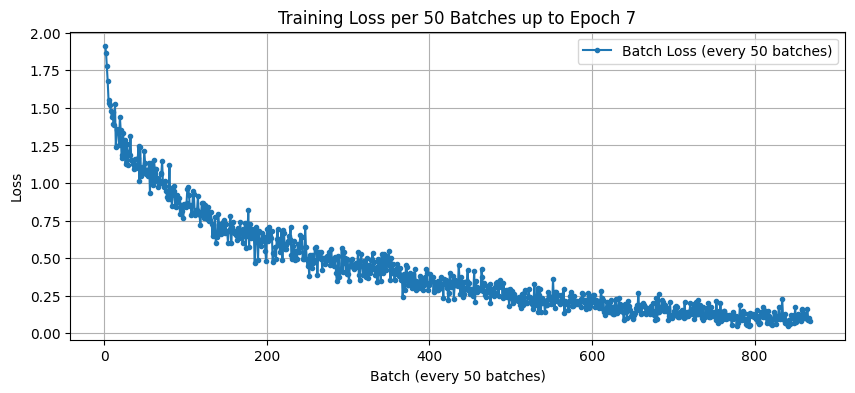

Epoch 8/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.38it/s, loss=0.0486]

Epoch 8/15 completed - Train Loss: 0.0829, Val Loss: 0.2257, Val Accuracy: 93.04%, Val Precision: 0.8737, Val Recall: 0.9433




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


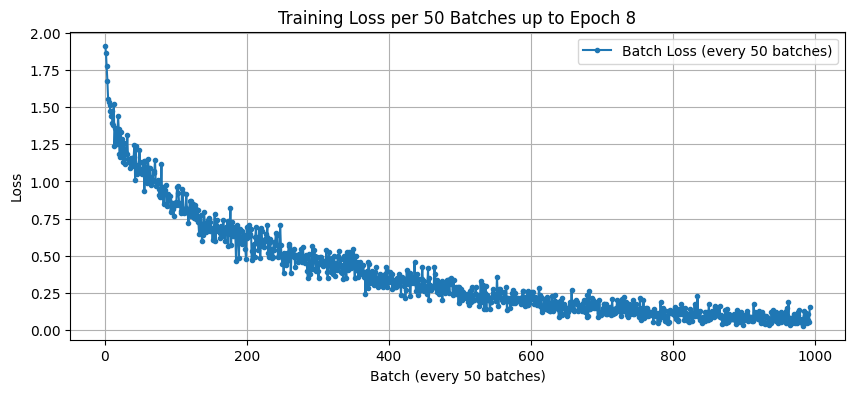

Epoch 9/15 [Val]: 100%|██████████| 2077/2077 [00:49<00:00, 41.59it/s, loss=0.4934]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 9/15 completed - Train Loss: 0.0634, Val Loss: 0.1972, Val Accuracy: 93.96%, Val Precision: 0.8899, Val Recall: 0.9550

Best model saved at epoch 9 with val loss: 0.1972


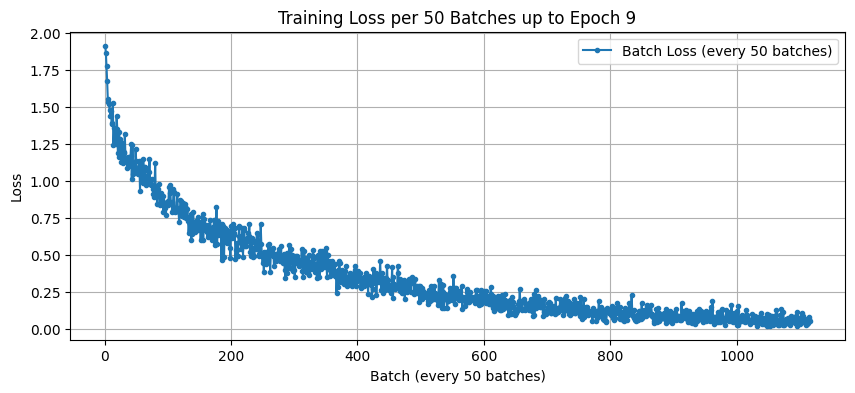

Epoch 10/15 [Val]: 100%|██████████| 2077/2077 [00:53<00:00, 38.76it/s, loss=0.8118]

Epoch 10/15 completed - Train Loss: 0.0566, Val Loss: 0.2222, Val Accuracy: 93.24%, Val Precision: 0.9043, Val Recall: 0.9438




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


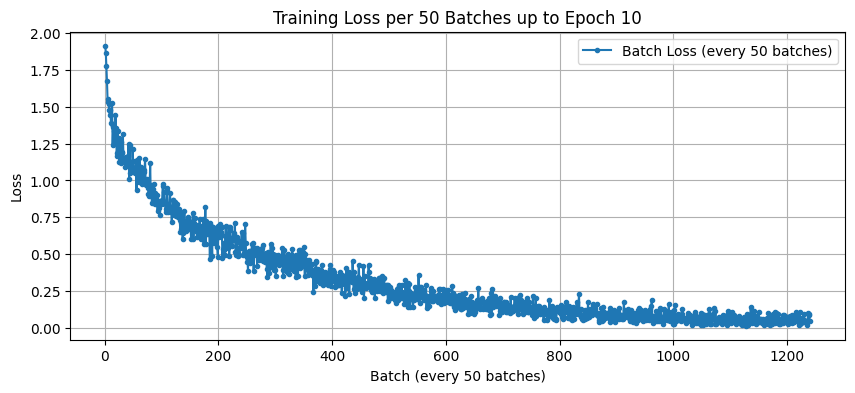

Epoch 11/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.33it/s, loss=1.2553]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 11/15 completed - Train Loss: 0.0469, Val Loss: 0.1825, Val Accuracy: 94.51%, Val Precision: 0.9376, Val Recall: 0.9564

Best model saved at epoch 11 with val loss: 0.1825


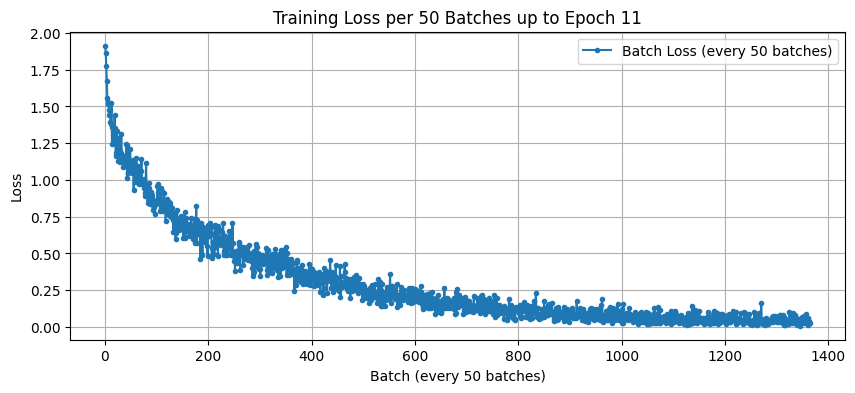

Epoch 12/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.39it/s, loss=0.1010]
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 12/15 completed - Train Loss: 0.0373, Val Loss: 0.1798, Val Accuracy: 94.97%, Val Precision: 0.9412, Val Recall: 0.9529

Best model saved at epoch 12 with val loss: 0.1798


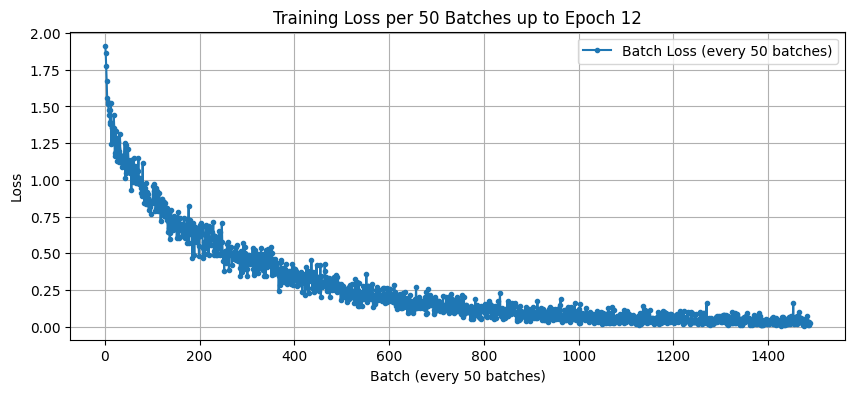

Epoch 13/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.25it/s, loss=0.0128]

Epoch 13/15 completed - Train Loss: 0.0359, Val Loss: 0.1768, Val Accuracy: 94.68%, Val Precision: 0.9099, Val Recall: 0.9623

Best model saved at epoch 13 with val loss: 0.1768



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


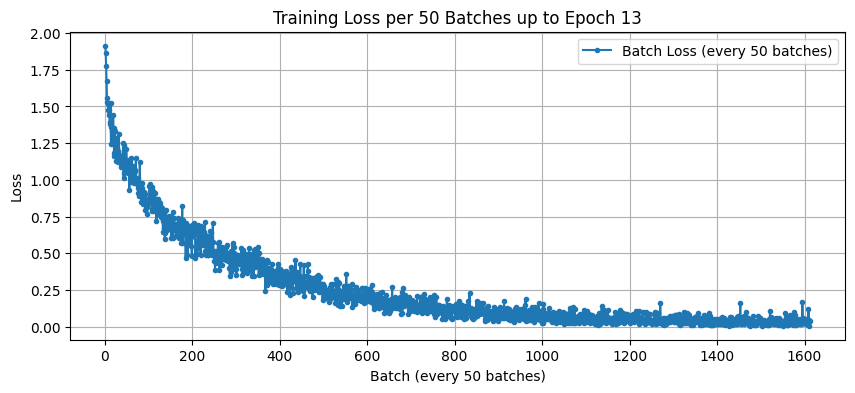

Epoch 14/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.41it/s, loss=0.3799]

Epoch 14/15 completed - Train Loss: 0.0281, Val Loss: 0.1948, Val Accuracy: 94.86%, Val Precision: 0.9264, Val Recall: 0.9632




c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


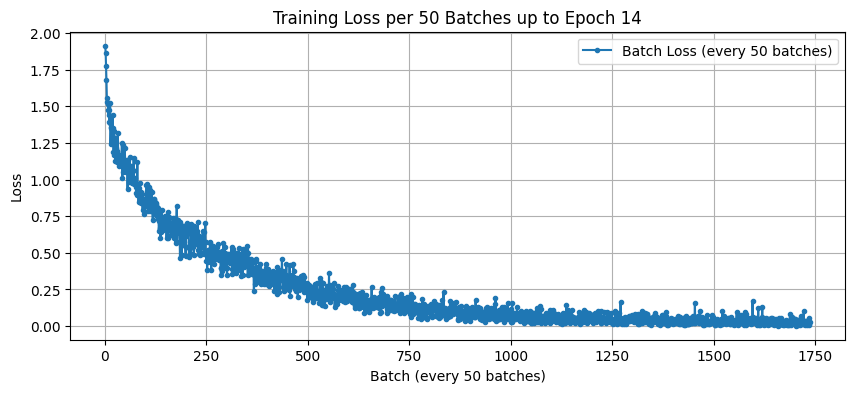

Epoch 15/15 [Val]: 100%|██████████| 2077/2077 [00:50<00:00, 41.17it/s, loss=0.0824]  

Epoch 15/15 completed - Train Loss: 0.0269, Val Loss: 0.2937, Val Accuracy: 93.39%, Val Precision: 0.9009, Val Recall: 0.9526

Early stopping triggered after 15 epochs.



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


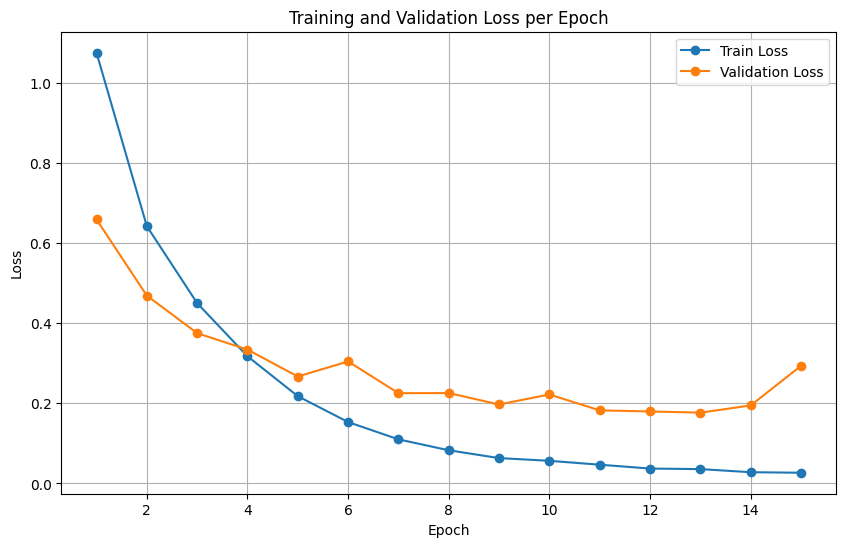

In [6]:
# Hyperparams:
lr = 1e-5
train_ratio = 0.75
batch_size = 4
epochs = 15
early_stop_patience = 2
N_freeze = 0 # max value 6 because totally 7 blocks
best_model_path = 'best_model_n_0_cosine_custom_head_s.pt'

data_dir = "C:/Users/User/images/450/"

# Define transforms: convert to tensor and normalize as per ImageNet stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
print(f"Found {num_classes} classes: {dataset.classes}")

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True)

# Adding custom layers with dropout:
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

if N_freeze > 0:
    for param in model.conv_stem.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for idx, block in enumerate(model.blocks.children()):
        if idx < N_freeze:
            for param in block.parameters():
                param.requires_grad = False
        else:
            break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Trying different schedulers:

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses, val_losses = [], []
batch_losses = []

best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    epoch_batch_losses = []
    train_bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}/{epochs} [Train]")

    for batch_idx, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        batch_loss += loss.item()

        if batch_idx % 50 == 0:
            avg_batch_loss = batch_loss / 50
            epoch_batch_losses.append(avg_batch_loss)
            batch_loss = 0.0

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    batch_losses.extend(epoch_batch_losses)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels, all_preds = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Epoch {epoch}/{epochs} completed - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}\n")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} with val loss: {best_val_loss:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(batch_losses) + 1), batch_losses, label='Batch Loss (every 50 batches)', marker='.')
    plt.xlabel('Batch (every 50 batches)')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per 50 Batches up to Epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()